In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import logging

# logger = logging.basicConfig(level=logging.INFO)

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["font.size"] = 12

## install dependencies

In [2]:
# !mamba install -c conda-forge -y make proj-data sentinelsat xmlschema

In [3]:
# !pip install elevation sarsen xarray-sentinel

In [4]:
import os

import numpy as np
import rioxarray  # enable the `.rio` accessor
import xarray as xr

from sarsen import apps, scene

## processing definition

In [5]:
os.makedirs("data", exist_ok=True)
dem_urlpath = "data/South-of-Redmond-10m.tif"
dem_10m_UTM_urlpath = dem_urlpath.strip(".tif") + "_UTM.tif"
dem_raster_10m_UTM_crop_urlpath = dem_10m_UTM_urlpath.strip(".tif") + "_crop.tif"

product_folder = "GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048"
measurement_group = "IW/VV"

## download DEM

In [ ]:
import adlfs
import planetary_computer
import pystac_client
import stackstac

In [ ]:
seattle = [-121.95, 47.04]
areas_of_interest = {"type": "Point", "coordinates": seattle}

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
threedep = catalog.get_child(id="3dep-seamless")

longitude, latitude = seattle
buffer = 0.2
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
search = catalog.search(collections="3dep-seamless", bbox=bbox)
items = list(search.get_items())
items

In [ ]:
items_high_res = [
    planetary_computer.sign(item).to_dict()
    for item in items
    if item.properties["gsd"] == 10
]

dem_raster_all = stackstac.stack(items_high_res, bounds=bbox).squeeze()
dem_raster_all

In [ ]:
dem_raster = dem_raster_all.compute()
if "time" in dem_raster.dims:
    dem_raster = dem_raster.mean("time")
dem_raster.rio.set_crs(dem_raster_all.rio.crs)
dem_raster.rio.to_raster(dem_urlpath)

### RESAMPLING UTM DEM

#### 10 meters

In [ ]:
dem_raster

In [ ]:
t_srs = dem_raster.rio.estimate_utm_crs()
str(t_srs)

In [ ]:
! export t_srs=str(t_srs), dem_urlpath={dem_urlpath}; export dem_10m_UTM_urlpath={dem_10m_UTM_urlpath}; gdalwarp -r bilinear -s_srs EPSG:4326+5773 -t_srs {t_srs} -tr 10 10 -overwrite -ot Float32 -co COMPRESS=DEFLATE {dem_urlpath} {dem_10m_UTM_urlpath}
        

In [ ]:
corners = dict(x=slice(565000, 595000), y=slice(5190000, 5220000))

In [ ]:
dem_raster_10m_UTM = scene.open_dem_raster(dem_10m_UTM_urlpath)
dem_raster_10m_UTM.plot()

In [ ]:
dem_raster_10m_UTM = scene.open_dem_raster(dem_10m_UTM_urlpath)
dem_raster_10m_UTM = dem_raster_10m_UTM.sel(**corners)
dem_raster_10m_UTM

In [ ]:
_ = dem_raster_10m_UTM.plot()

In [ ]:
dem_raster_10m_UTM.rio.to_raster(dem_10m_UTM_urlpath)

## download data

In [ ]:
import os


def mirror_folder(fs, bucket, folder, exclude="vh"):
    for path, folders, files in fs.walk(f"{bucket}/{folder}"):
        os.makedirs(path[len(bucket) + 1 :], exist_ok=True)
        for f in files:
            if exclude in f:
                continue
            file_path = os.path.join(path, f)
            lfile_path = file_path[len(bucket) + 1 :]
            if not os.path.isfile(lfile_path):
                print(file_path)
                fs.download(file_path, lfile_path + "~")
                os.rename(lfile_path + "~", lfile_path)

In [ ]:
grd_account_name = "sentinel1euwest"
grd_bucket = "s1-grd"
grd_token = planetary_computer.sas.get_token(grd_account_name, grd_bucket).token

grd_product_folder = f"{grd_bucket}/{product_folder}"

grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(grd_product_folder)

In [ ]:
mirror_folder(grd_fs, grd_bucket, product_folder)

In [ ]:
ds = xr.open_dataset(
    product_folder,
    engine="sentinel-1",
    group=measurement_group,
    # storage_options=storage_options,
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    chunks={"slant_range_time": 2048},
)
ds

In [ ]:
rtc_account_name = "sentinel1euwestrtc"
rtc_bucket = "sentinel1-grd-rtc"
rtc_token = planetary_computer.sas.get_token(rtc_account_name, rtc_bucket).token

rtc_product_folder = f"{rtc_bucket}/{product_folder}"

rtc_fs = adlfs.AzureBlobFileSystem(rtc_account_name, credential=rtc_token)
rtc_fs.ls(rtc_product_folder)

In [ ]:
mirror_folder(rtc_fs, rtc_bucket, product_folder)

## process

#### GTC

In [6]:
%%time

gtc_path = os.path.basename(product_folder) + ".GTC.tif"

gtc = apps.terrain_correction(
    product_folder,
    measurement_group,
    dem_10m_UTM_urlpath,
    interp_method="nearest",
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    chunks={"slant_range_time": 2048},
    output_urlpath=gtc_path,
)

!gdaladdo -r average {gtc_path}

gtc_path

0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 1min 2s, sys: 39.7 s, total: 1min 41s
Wall time: 2min


'S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048.GTC.tif'

In [ ]:
gtc.plot(vmax=0.4);

#### RTC

In [7]:
%%time

rtc_path = os.path.basename(product_folder) + ".RTC.tif"

rtc = apps.terrain_correction(
    product_folder,
    measurement_group,
    dem_10m_UTM_urlpath,
    interp_method="nearest",
    override_product_files="{dirname}/{prefix}{swath}-{polarization}{ext}",
    correct_radiometry="gamma_nearest",
    output_urlpath=rtc_path,
    grouping_area_factor=(1, 1),
)

!gdaladdo -r average {rtc_path}

rtc_path

0...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 2min 47s, sys: 1min 2s, total: 3min 50s
Wall time: 4min 37s


'S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048.RTC.tif'

In [ ]:
rtc.plot(vmax=0.4);

## Gamma vs Incidence Angle

#### Compute local incidence angle

In [8]:
dem_raster_10m_UTM = scene.open_dem_raster(dem_10m_UTM_urlpath)

measurement_ds, kwargs = apps.open_dataset_autodetect(
    product_folder,
    group=measurement_group,
)


orbit_ecef = xr.open_dataset(product_folder, engine="sentinel-1", group=f"{measurement_group}/orbit", **kwargs)
dem_ecef = scene.convert_to_dem_ecef(dem_raster_10m_UTM)

acquisition = apps.simulate_acquisition(dem_ecef, orbit_ecef.position)
oriented_area = scene.compute_dem_oriented_area(dem_ecef)
dem_normal = -oriented_area / np.sqrt(xr.dot(oriented_area, oriented_area, dims="axis"))

In [9]:
angle = np.arccos(xr.dot(dem_normal, acquisition.dem_direction, dims="axis"))

#### Load Data

In [10]:
angle = angle.load()
gtc = gtc.load()
rtc = rtc.load()

#### GTC and RTC distribution of foreslope backslope anf flat terrain 

In [11]:
# incidence angle on ellipsoid is about 3.9 degree in this zone
ellipsoid_incidence = 39.0 / 180 * np.pi 
ellipsoid_incidence

0.6806784082777886

In [12]:
## foreslope backslope and flat terrain  
gtc_backslope = xr.where(angle < ellipsoid_incidence - 0.2 , gtc, np.nan)
gtc_foreslope = xr.where(angle > ellipsoid_incidence + 0.2, gtc, np.nan)
gtc_flat = xr.where((angle < ellipsoid_incidence + 0.2) & (angle > ellipsoid_incidence - 0.2), gtc, np.nan)

rtc_backslope = xr.where(angle < ellipsoid_incidence - 0.2, rtc, np.nan)
rtc_foreslope = xr.where(angle > 1, rtc, np.nan)
rtc_flat = xr.where((angle < ellipsoid_incidence + 0.2) & (angle > ellipsoid_incidence - 0.2), rtc, np.nan)

Text(0.5, 0, 'gamma_T')

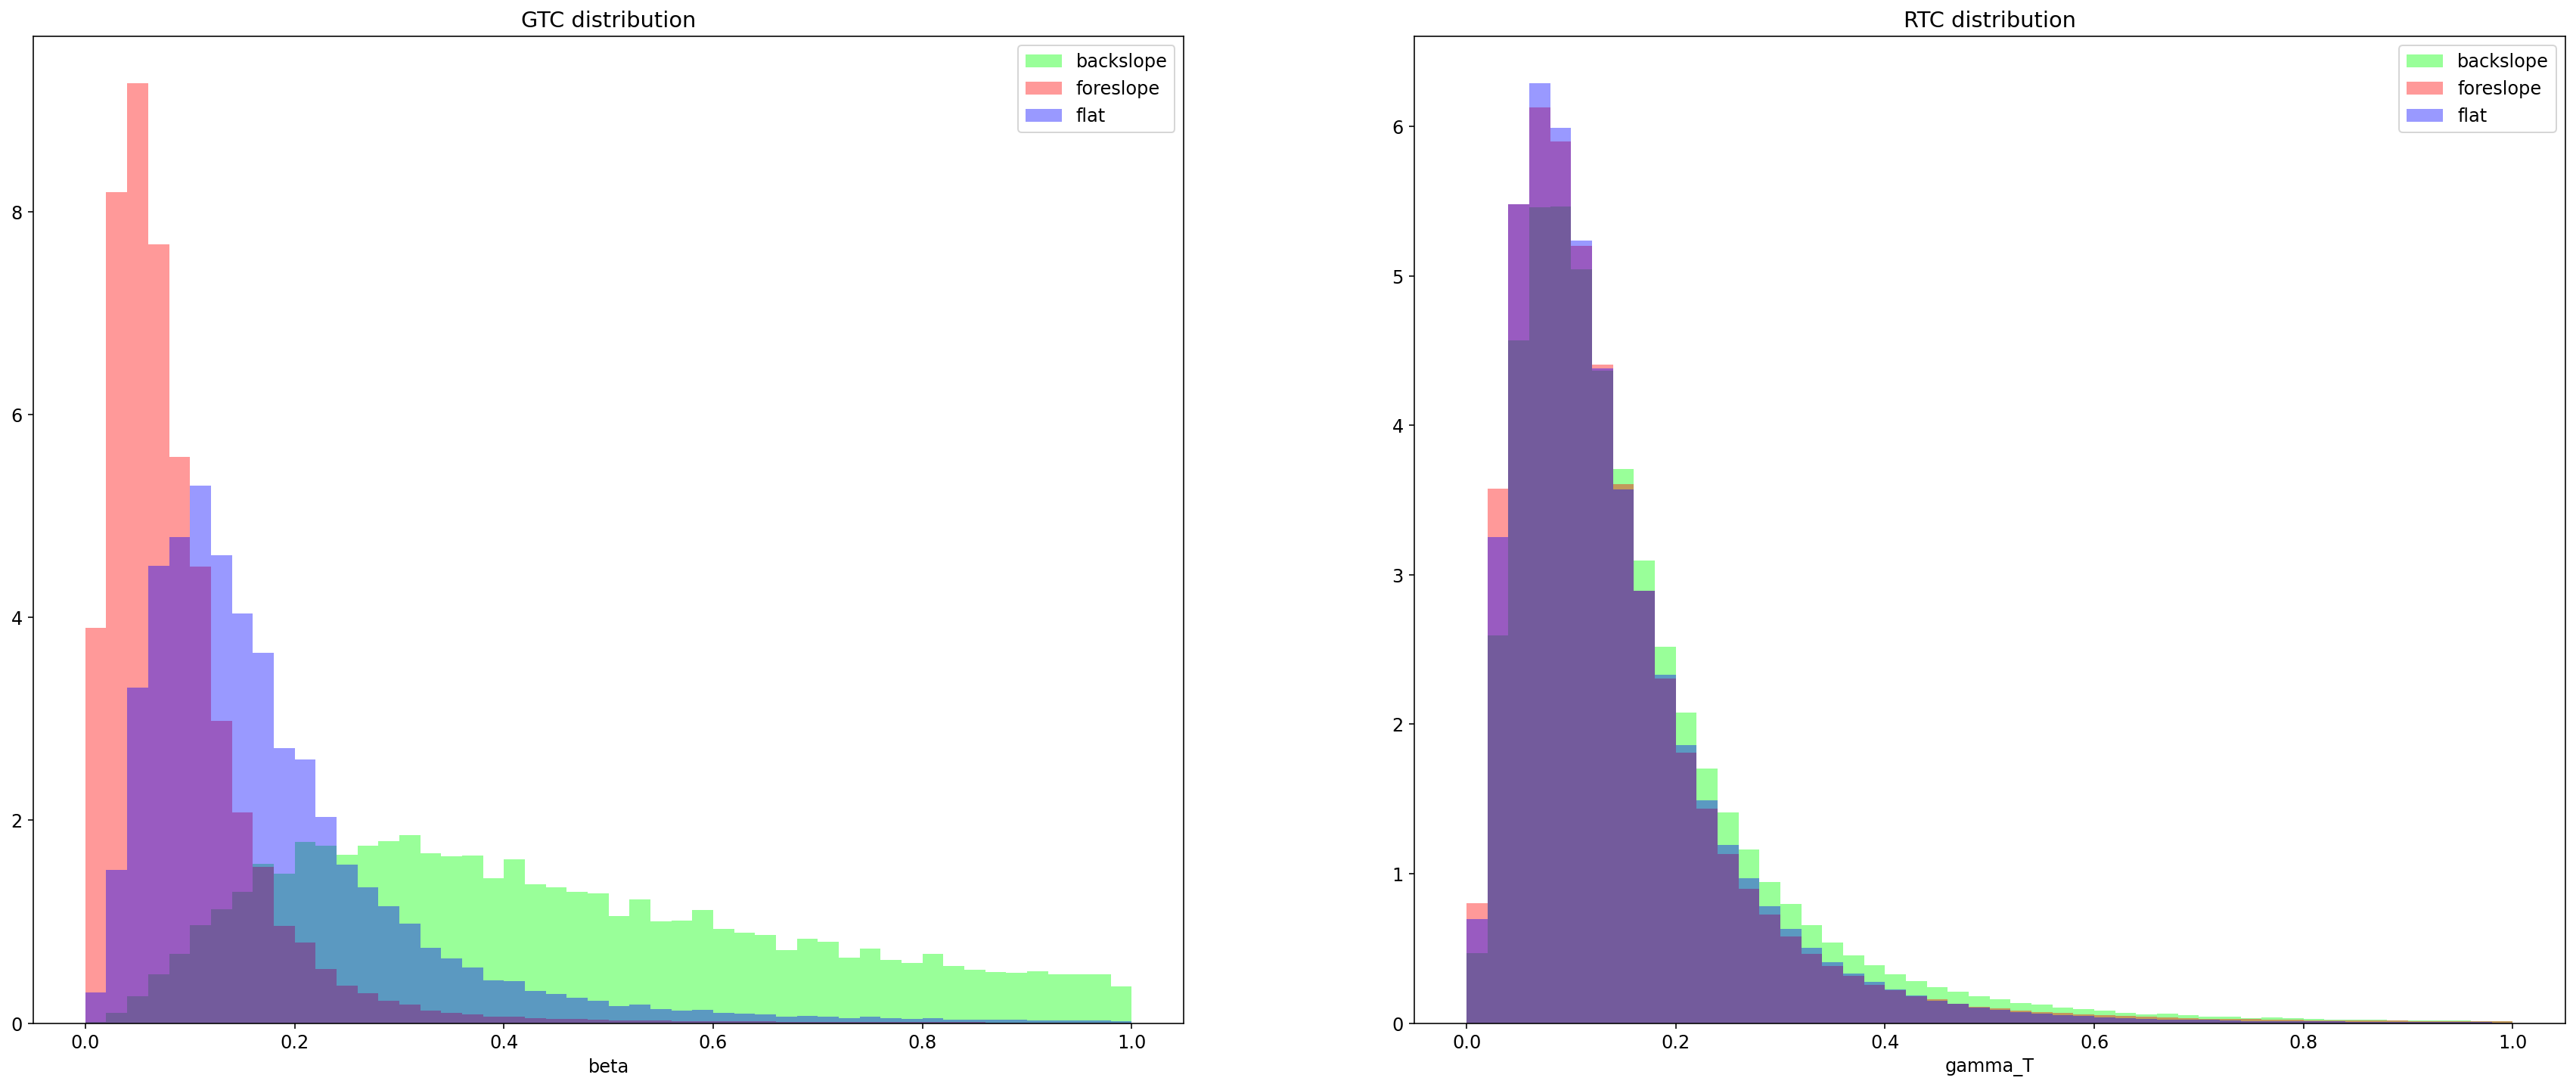

In [13]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))

gtc_backslope_h = xr.plot.hist(gtc_backslope, range=[0, 1], bins=50, color=[0, 1, 0, 0.4], density=True, ax=axes[0], label="backslope")
gtc_foreslope_h = xr.plot.hist(gtc_foreslope, range=[0, 1], bins=50, color=[1, 0, 0, 0.4], density=True, ax=axes[0], label="foreslope")
gtc_flat_h = xr.plot.hist(gtc_flat, range=[0, 1], bins=50, color=[0, 0, 1, 0.4], density=True, ax=axes[0], label="flat")

rtc_backslope_h = xr.plot.hist(rtc_backslope, range=[0, 1], bins=50, color=[0, 1, 0, 0.4], density=True, ax=axes[1], label="backslope")
rtc_foreslope_h = xr.plot.hist(rtc_foreslope, range=[0, 1], bins=50, color=[1, 0, 0, 0.4], density=True, ax=axes[1], label="foreslope")
rtc_flat_h = xr.plot.hist(rtc_flat, range=[0, 1], bins=50, color=[0, 0, 1, 0.4], density=True, ax=axes[1], label="flat")

axes[0].legend()
axes[1].legend()

axes[0].set_title("GTC distribution")
axes[0].set_xlabel("beta")

axes[1].set_title("RTC distribution")
axes[1].set_xlabel("gamma_T")

In [14]:
gtc_backslope_db = np.log(gtc_backslope)
gtc_foreslope_db = np.log(gtc_foreslope)
gtc_flat_db = np.log(gtc_flat)

rtc_backslope_db = np.log(rtc_backslope)
rtc_foreslope_db = np.log(rtc_foreslope)
rtc_flat_db = np.log(rtc_flat)

axes[0].legend()
axes[1].legend()

/usr/local/Caskroom/miniconda/base/envs/sarsen3/lib/python3.10/site-packages/xarray/core/computation.py:767: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Text(0.5, 0, 'gamma_T DB')

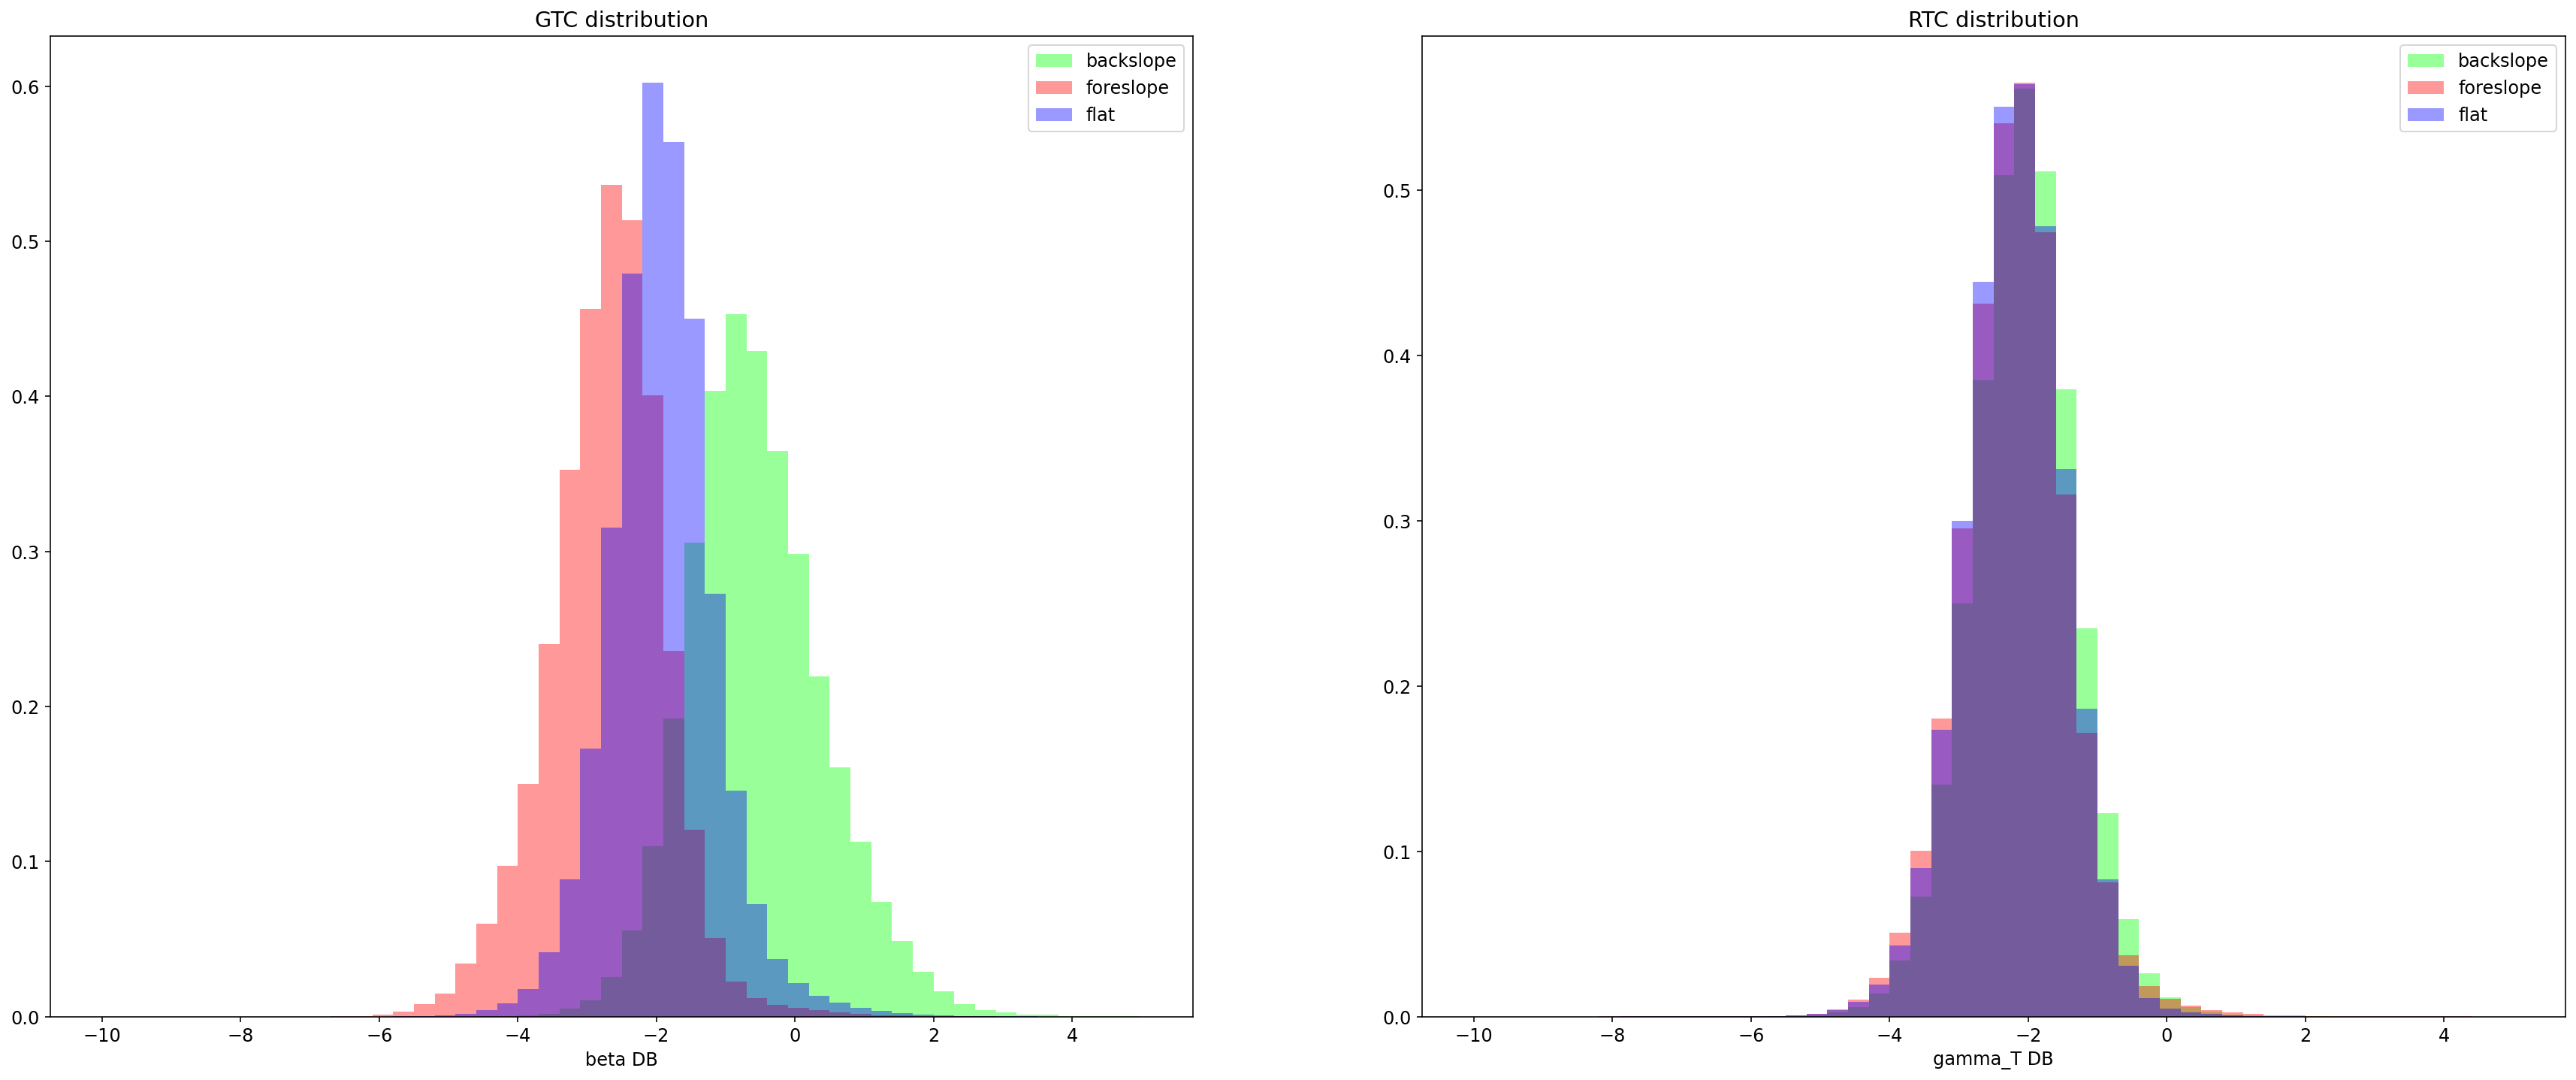

In [15]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))

gtc_backslope_db_h = xr.plot.hist(gtc_backslope_db, range=[-10, 5], bins=50, color=[0, 1, 0, 0.4], density=True, ax=axes[0], label="backslope")
gtc_foreslope_db_h = xr.plot.hist(gtc_foreslope_db, range=[-10, 5], bins=50, color=[1, 0, 0, 0.4], density=True, ax=axes[0], label="foreslope")
gtc_flat_db_h = xr.plot.hist(gtc_flat_db, range=[-10, 5], bins=50, color=[0, 0, 1, 0.4], density=True, ax=axes[0], label="flat")

rtc_backslope_db_h = xr.plot.hist(rtc_backslope_db, range=[-10, 5], bins=50, color=[0, 1, 0, 0.4], density=True, ax=axes[1], label="backslope")
rtc_foreslope_db_h = xr.plot.hist(rtc_foreslope_db, range=[-10, 5], bins=50, color=[1, 0, 0, 0.4], density=True, ax=axes[1], label="foreslope")
rtc_flat_db_h = xr.plot.hist(rtc_flat_db, range=[-10, 5], bins=50, color=[0, 0, 1, 0.4], density=True, ax=axes[1], label="flat")
axes[0].legend()
axes[1].legend()

axes[0].set_title("GTC distribution")
axes[0].set_xlabel("beta DB")

axes[1].set_title("RTC distribution")
axes[1].set_xlabel("gamma_T DB")


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm


def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

def plot_density(x, y, ax=None):
    if ax is None:
        ax = plt
    mask = np.logical_and(np.isfinite(y), np.isfinite(x))
    samples = np.stack([x[mask], y[mask]])
    
    densObj = kde(samples)
    colours = makeColours(densObj.evaluate( samples ))
    fig = ax.scatter(samples[0], samples[1], color=colours)
    return fig


In [17]:
gtc_db = np.log(gtc).load()
rtc_db = np.log(rtc).load()
angle = angle.load()

Text(0, 0.5, 'incidence angle')

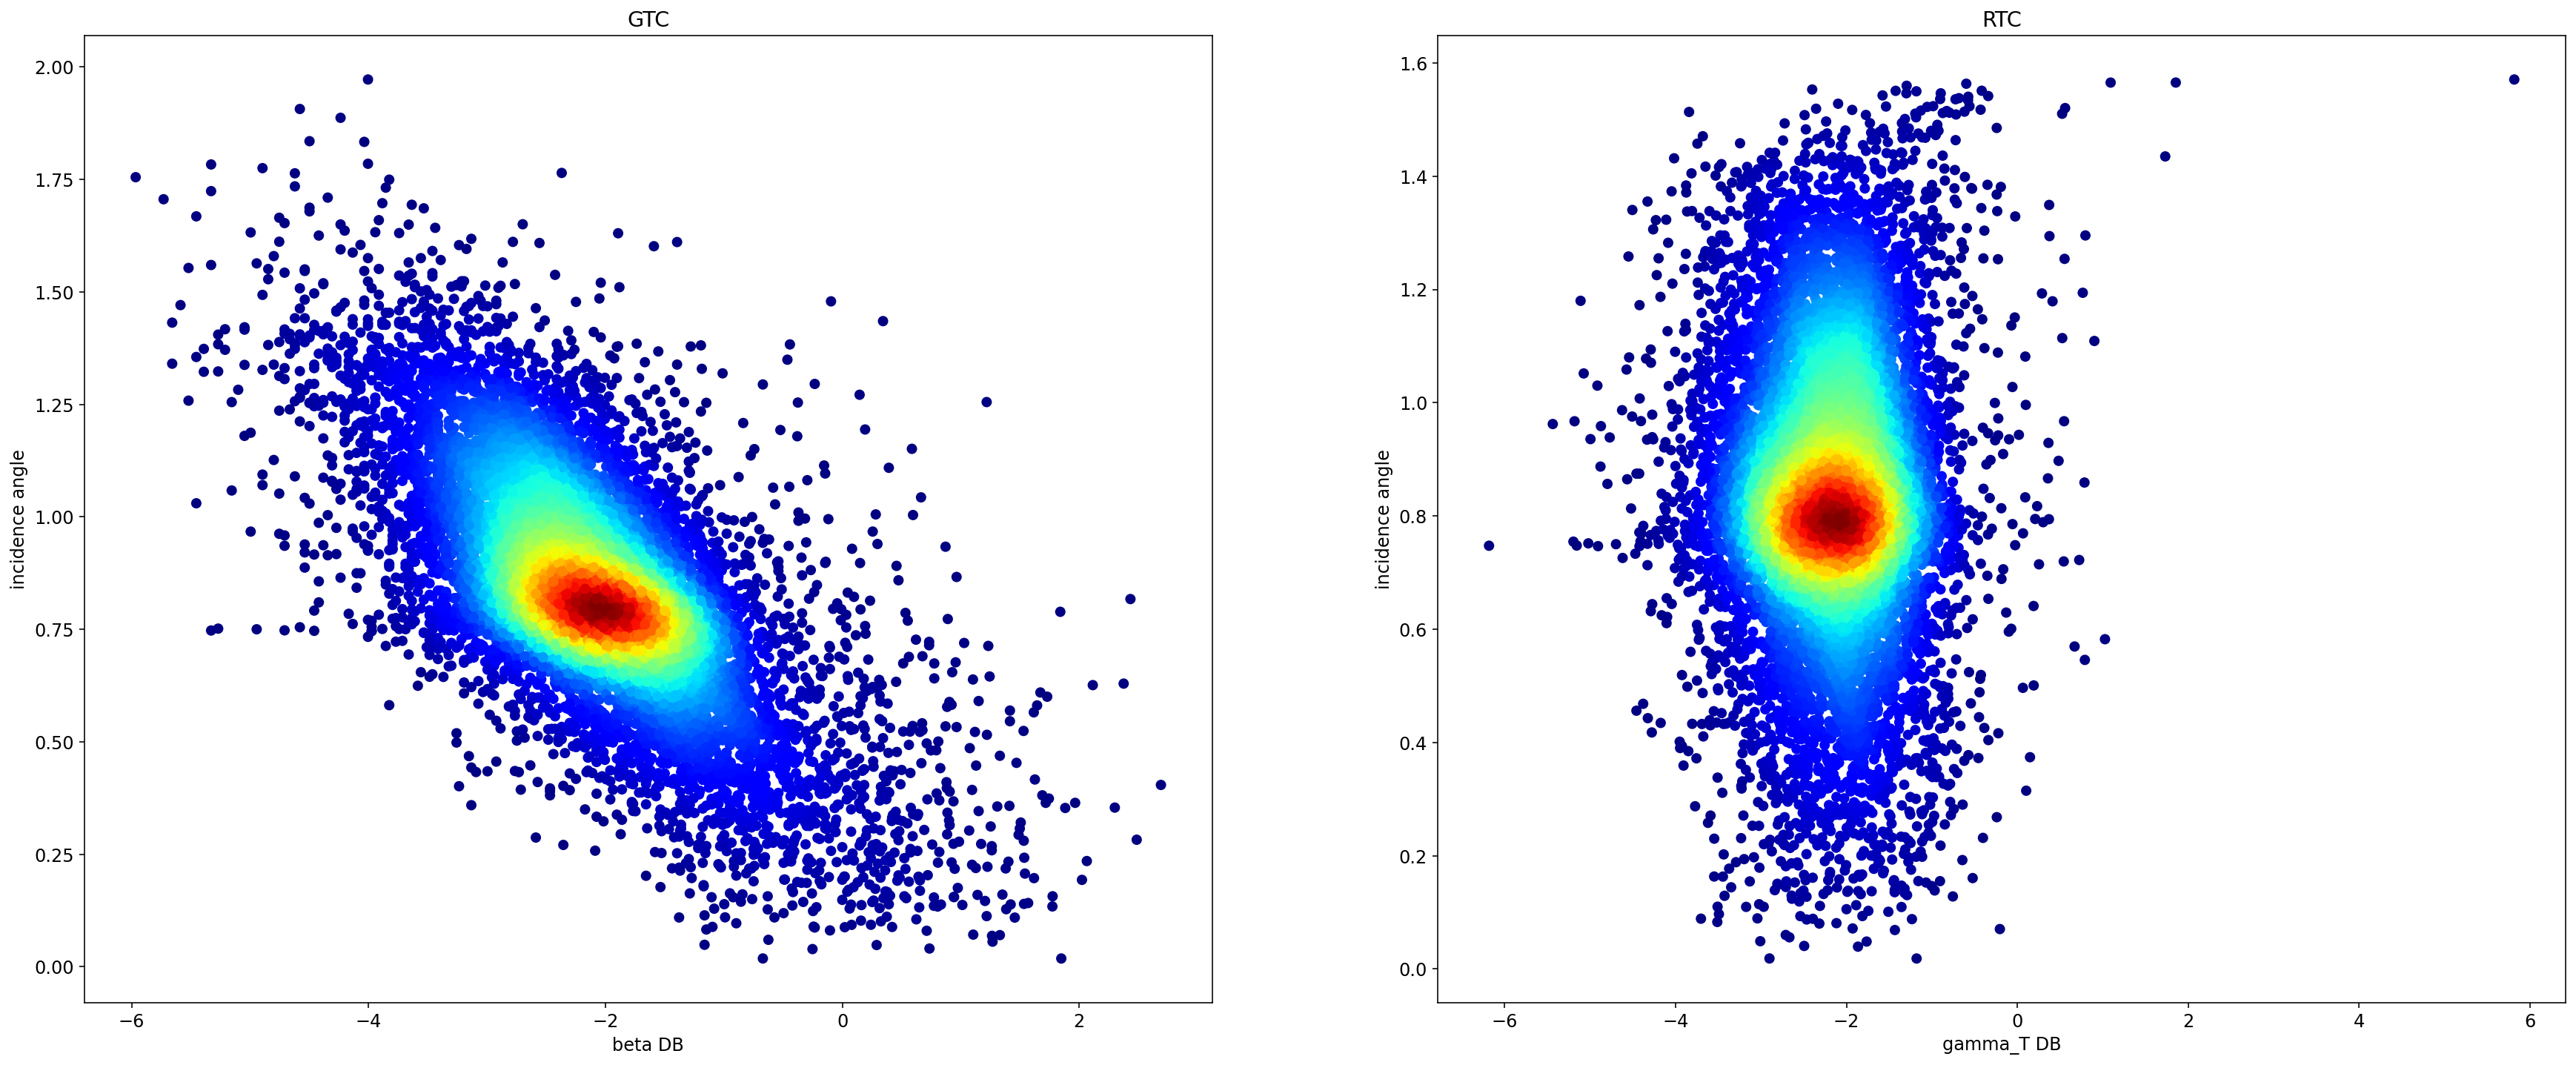

In [18]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12))

fig = plot_density(gtc_db[::30, ::30].data.ravel(), angle[::30, ::30].data.ravel(), ax=axes[0])
fig = plot_density(rtc_db[::30, ::30].data.ravel(), angle[::30, ::30].data.ravel(), ax=axes[1])

axes[0].set_title("GTC")
axes[0].set_xlabel("beta DB")
axes[0].set_ylabel("incidence angle")

axes[1].set_title("RTC")
axes[1].set_xlabel("gamma_T DB")
axes[1].set_ylabel("incidence angle")
